# Assignmnet 2 (100 points)

**Name:** Jiahui Dai<br>
**Email:** jid4620@thi.de<br>
**Group:** B <br>
**Hours spend *(optional)* :** <br>

In [227]:
# Import modules
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict, defaultdict
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re
import math
# from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [228]:
##############################
### To load stopwords
### Generated from ChatGPT
##############################

import ssl
import certifi
import urllib.request
import nltk

# Set up SSL context using certifi
context = ssl.create_default_context(cafile=certifi.where())

# Patch urllib with the custom context for NLTK downloader
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=context)))

# Now download the stopwords resource
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jiahuidai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [229]:
# Load filenames
data_folder = "sms_spam_collection"
sms_spam_collection = os.path.join(data_folder, "SMSSpamCollection")

### SMS Spam Detection *(60 points)*

<p>You are hired as an AI expert in the development department of a telecommunications company. The first thing on your orientation plan is a small project that your boss has assigned you for the following given situation. Your supervisor has given away his private cell phone number on too many websites and is now complaining about daily spam SMS. Therefore, it is your job to write a spam detector in Python. </p>

<p>In doing so, you need to use a Naive Bayes classifier that can handle both bag-of-words (BoW) and tf-idf features as input. For the evaluation of your spam detector, an SMS collection is available as a dataset - this has yet to be suitably split into train and test data. To keep the costs as low as possible and to avoid problems with copyrights, your boss insists on a new development with Python.</p>

<p>Include a short description of the data preprocessing steps, method, experiment design, hyper-parameters, and evaluation metric. Also, document your findings, drawbacks, and potential improvements.</p>

<p>Note: You need to implement the bag-of-words (BoW) and tf-idf feature extractor from scratch. You can use existing python libraries for other tasks.</p>

**Dataset and Resources**

* SMS Spam Collection Dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [230]:
# Load dataset
data = pd.read_csv(sms_spam_collection, sep='\t', header=None, names=['spam', 'message'])
data.head()

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [231]:
# Change spam's values to boolean
data['spam'] = data['spam'].map({'ham': False, 'spam': True})
data.head()

,spam,message
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."


In [232]:
# View summary of 'spam' column
data['spam'].value_counts()

spam
False    4825
True      747
Name: count, dtype: int64

In [233]:
# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(data['message'], data['spam'], test_size=0.2, random_state=42)

train_df = pd.DataFrame({
    'message': X_train,
    'spam': y_train
}).reset_index(drop=True)

test_df = pd.DataFrame({
    'message': X_test,
    'spam': y_test
}).reset_index(drop=True)

In [234]:
class OrderedCounter(Counter, OrderedDict):
    '''To create an ordered counter'''

    pass

In [ ]:
class NavieBayesClassifier():

    def __init__(self):
        pass

    @staticmethod
    def tokenize(corpus):
        """
        Tokenise corpus into individual words
        """
        words = re.split(r"\W+", corpus) # spilt based on non-alphanumeric
        words = [word.lower() for word in words if len(word) > 0] # lowercase words and ignore ''
        return words
    
    def preprocess(self, corpus):
        """
        To preprocess words
        1. Tokenisation
        2. Stop words removal
        3. Stemming
        """
        stop_words = stopwords.words('english')

        words = self.tokenize(corpus) # tokenize words
        words = [word for word in words if word not in stop_words] # remove stop words
        words = [PorterStemmer().stem(word) for word in words] # Stemming
        return words
    
    def bag_of_words(self, documents: pd.DataFrame):
        self.spam_counter = OrderedCounter() # total count
        self.ham_counter = OrderedCounter() # total count
        self.spam_bags = OrderedCounter() # document count
        self.ham_bags = OrderedCounter() # document count
        self.spam_len = documents["spam"].value_counts()[True]
        self.ham_len = documents["spam"].value_counts()[False]

        for i, row in documents.iterrows():
            msg = self.preprocess(row["message"])
            spam = row["spam"]

            # Tag document to the corresponding Counter
            if spam:
                self.spam_counter.update(msg)
                self.spam_bags.update(set(msg))
            else:
                self.ham_counter.update(msg)
                self.ham_bags.update(set(msg))

        self.words_counter = self.spam_counter + self.ham_counter

    def tf_idf(self, t, d=None):
        """
        t: word/token
        d: Counter of all tokens in corpus
        """
        # Term Frequency
        t_terms_appearance = self.words_counter.get(t, 0)
        word_count = sum(self.words_counter.values())
        tf = t_terms_appearance / word_count if word_count > 0 else 0

        # Inverse Document Frequency
        total_doc = self.ham_len + self.spam_len
        t_appearance = self.spam_bags.get(t, 0) + self.ham_bags.get(t, 0)
        idf = math.log(total_doc / t_appearance) if t_appearance > 0 else 0

        # TF-IDF
        return tf * idf
    
    def probability(self, message, spam: bool, alpha=1):
        """
        Probability calculation of message given spam label
        Equation 2-3
        """
        # b = 1 if spam else 0
        epsilon = 1e-10  # prevents log2(0)

        log_sum = 0
        for word in self.preprocess(message):
            P_xi_wj = max(self.cond_prob(word, spam, alpha), epsilon)
            log_prob = math.log2(P_xi_wj)
            log_sum += log_prob

        return 2 ** log_sum
    

    def cond_prob(self, word, spam: bool, alpha=1):
        """
        Probability calculation of word given spam label
        Equation 1-2 (account for laplace smoothing)
        """
        V = len(self.words_counter)
        if spam:
            num = self.spam_counter.get(word, alpha)
            denom = sum(self.spam_counter.values()) + alpha * V
        else: 
            num = self.ham_counter.get(word, alpha)
            denom = sum(self.ham_counter.values()) + alpha * V

        return num / denom


    def spamminess(self, word, s=1, alpha=1):

        p_spam = self.spam_len / (self.ham_len + self.spam_len)
        n = self.words_counter.get(word)
        log_p_spam_X = math.log2(self.cond_prob(word, True, alpha))

        return (s * p_spam + n * 2**log_p_spam_X) / (s + n)


    def spam_decision(self, message, alpha=1):
        """
        To determine if a given message is spam or ham
        = posterior probability
        Equation 4-10
        """
        # Prior probabilities P(w_j)
        log_p_spam = math.log2(self.prior_probability(spam=True)) # - Eq. 8
        log_p_ham = math.log2(self.prior_probability(spam=False)) # - Eq. 9

        # Class-conditional probabilities (P(X | w_j))
        log_p_X_spam = math.log2(self.probability(message, True, alpha)) # - P(X | spam); Eq. 3
        log_p_X_ham = math.log2(self.probability(message, False, alpha)) # - P(X | ham); Eq. 3

        # Evidence
        # P(X) is not calculated as it is a common denominator for comparison

        # Posterior probabilities P(w_j | X)
        log_p_spam_X = log_p_X_spam + log_p_spam # - Eq. 5
        log_p_ham_X = log_p_X_ham + log_p_ham # - Eq. 6

        # print(f"Msg: {message}")
        # print(f"P(spam|X): {2 ** log_p_spam_X:.6f}, P(ham|X): {2 ** log_p_ham_X:.6f}, decision: {log_p_spam_X >= log_p_ham_X}")
        # print("-"*30)

        # Eq. 4 - Decision
        return log_p_spam_X >= log_p_ham_X

    def prior_probability(self, spam: bool):
        """
        Probability of class
        P(w_j) - Eq. 8 & 9
        """

        total_len = self.spam_len + self.ham_len

        if spam:
            return self.spam_len / total_len
        else:
            return self.ham_len / total_len



    def train(self, train_df):
        self.bag_of_words(train_df)

    def test(self, test_df, alpha=1):
        self.prediction_df = test_df.copy()
        self.prediction_df["predicted"] = test_df["message"].apply(lambda msg: self.spam_decision(msg, alpha))
        self.evaluate_metrics()

    def evaluate_metrics(self):
        actual = self.prediction_df["spam"]
        predicted = self.prediction_df["predicted"]
        TP = ((actual == True) & (predicted == True)).sum()
        TN = ((actual == False) & (predicted == False)).sum()
        FP = ((actual == False) & (predicted == True)).sum()
        FN = ((actual == True) & (predicted == False)).sum()
        beta = 1

        self.accuracy = (TP + TN) / (len(self.prediction_df))
        self.recall = (TP) / (TP + FN)
        self.fpr = (FP) / (FP + TN)
        self.precision = (TP) / (TP + FP)
        self.f1 = (1 + beta**2) * (self.precision * self.recall) / (beta**2 * self.precision + self.recall)
        self.mcc = (TP * TN - FP * FN) / math.sqrt((TP+FP) * (TP+FN) * (TN+FP) * (TN+FN))

    def print_metrics(self):
        print(f"Accuracy: {self.accuracy}\nRecall: {self.recall}\nFalse positive rate: {self.fpr}\nPrecision: {self.precision}")


In [236]:
model = NavieBayesClassifier()
model.train(train_df)
model.test(test_df, alpha=1)

In [237]:
model.prediction_df["predicted"].value_counts()

predicted
False    955
True     160
Name: count, dtype: int64

In [238]:
model.print_metrics()

Accuracy: 0.9811659192825112
Recall: 0.9664429530201343
False positive rate: 0.016563146997929608
Precision: 0.9


Generate graph on TF-IDF values with words

In [239]:
class NBC_only_tokenization(NavieBayesClassifier):

    def __init__(self):
        super().__init__()

    def preprocess(self, corpus):
        """
        To preprocess words
        1. Tokenisation
        """

        words = self.tokenize(corpus) # tokenize words
        return words

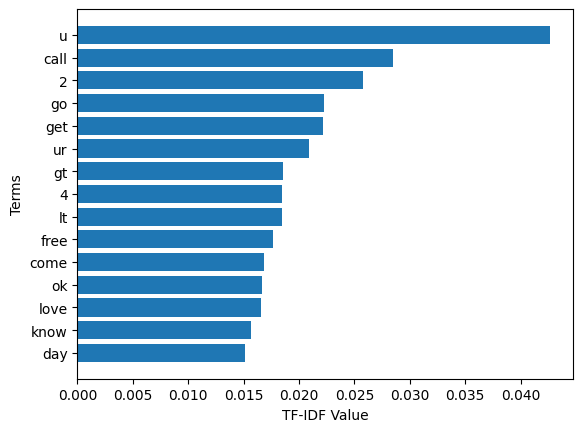

In [240]:
def return_top_terms_tfidf(model, n=15):
    sorted_terms = sorted(model.words_counter.keys(), key=lambda word: model.tf_idf(word), reverse=True)
    top_terms = sorted_terms[:n]
    top_tfidf = [model.tf_idf(word) for word in top_terms]

    return top_terms, top_tfidf

train_terms, train_tfidf = return_top_terms_tfidf(model)

model2 = NBC_only_tokenization()
model2.train(train_df)
train_terms_2, train_tfidf_2 = return_top_terms_tfidf(model2)

# Create the plot
plt.barh(train_terms, train_tfidf, label='full preporcessing')
plt.xlabel('TF-IDF Value')
plt.ylabel('Terms')
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('output/preprocessing_all.png')
plt.show()

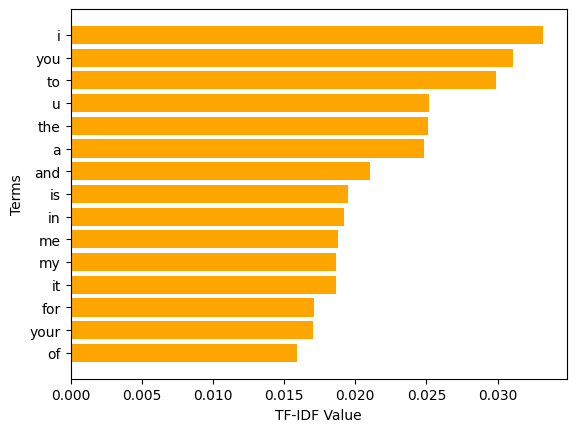

In [241]:
# Create the plot
plt.barh(train_terms_2, train_tfidf_2, label='only tokenisation', color='orange')
plt.xlabel('TF-IDF Value')
plt.ylabel('Terms')
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('output/preprocessing_tokenize.png')
plt.show()

Comparison between spaminess and TF-IDF

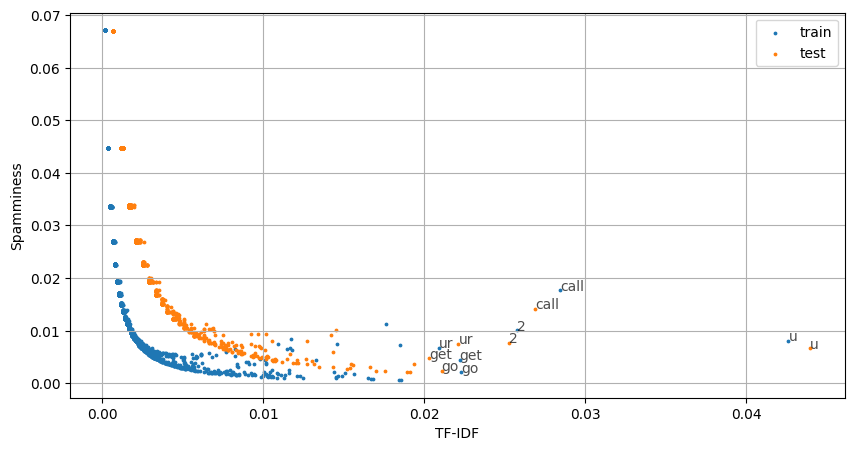

In [242]:
def return_tfidf_spamminess(model):
    word_dict = defaultdict(lambda: {'tf-idf': None, 'spamminess': None})

    for word in model.words_counter.keys():
        word_dict[word]['tf-idf'] = model.tf_idf(word)
        word_dict[word]['spamminess'] = model.spamminess(word)

    tf_idf = [info['tf-idf'] for word, info in word_dict.items()]
    spamminess = [info['spamminess'] for word, info in word_dict.items()]

    return word_dict, tf_idf, spamminess 

# Train data
train_word_data, train_tf_idf, train_spamminess = return_tfidf_spamminess(model)
# Test data
test_model = NavieBayesClassifier()
test_model.train(test_df)
test_word_data, test_tf_idf, test_spamminess = return_tfidf_spamminess(test_model)

plt.figure(figsize=(10, 5))
plt.scatter(train_tf_idf, train_spamminess, s=3, label='train')
plt.scatter(test_tf_idf, test_spamminess, s=3, label='test')

# Label selected points
for data in [train_word_data, test_word_data]:
    for word, info in data.items():
        tfidf = info['tf-idf']
        spam = info['spamminess']
        if tfidf > 0.02 or spam > 0.2:
            plt.annotate(word, (tfidf, spam), fontsize=10, alpha=0.7)


plt.xlabel('TF-IDF')
plt.ylabel('Spamminess')
plt.legend()
plt.savefig('output/tf-idf_spamminess.png')
plt.grid()
plt.show()

Comparison between models with different alpha smoothing

In [252]:
alpha = [0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]
accuracy = list()
recall = list()
fpr = list()
precision = list()
f1 = list()
mcc = list()

for a in alpha:
    m = NavieBayesClassifier()
    m.train(train_df)
    m.test(test_df, alpha=a)

    accuracy.append(m.accuracy)
    recall.append(m.recall)
    fpr.append(m.fpr)
    precision.append(m.precision)
    f1.append(m.f1)
    mcc.append(m.mcc)

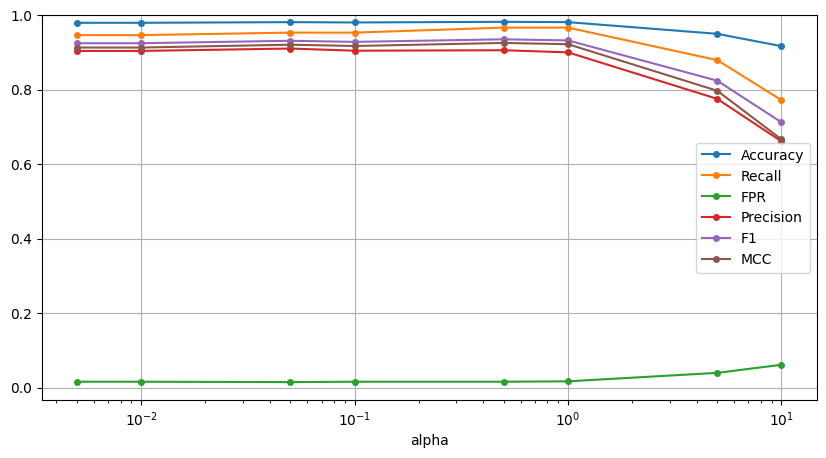

In [261]:
plt.figure(figsize=(10, 5))

metrics = [accuracy, recall, fpr, precision, f1, mcc]
labels = ['Accuracy', 'Recall', 'FPR', 'Precision', 'F1', 'MCC']
for metric, label in zip(metrics, labels):
    plt.plot(alpha, metric, marker='o', markersize=4, label=label)

plt.xlabel("alpha")
plt.xscale("log")
plt.ylim(top=1.0)
plt.legend()
plt.grid(True)
plt.show()

 ### Search Engine *(40 points)*

Your boss is impressed with your spam detector and assigns you a new task. As part of improving internal tools, the company wants a search engine that can search through SMS messages and rank them by relevance. Implement the PageRank algorithm from scratch to score each SMS message based on its importance in the document graph.

*   Compute TF-IDF vectors for all SMS messages (you can leverage previous implementation)
*   Construct a document graph, where each node represents an SMS message and edges are the links between nodes.
*  Implement the PageRank algorithm from scratch to assign an importance score to each SMS message based on its position in the document graph.

#### Hint : You can use the previous dataset or any dataset from your choice.




## You might need the follwoing formulas for your implementation

---

### 1) Cosine Similarity Between Two Document Vectors

Cosine similarity measures how similar two vectors are based on the angle between them:

$$
\text{cosine\_sim}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}
$$

- \( A \cdot B \): Dot product of vectors \( A \) and \( B \)  
- \( \|A\| \): Euclidean norm (magnitude) of vector \( A \)  
- \( \|B\| \): Euclidean norm of vector \( B \)

**Use case**: Comparing TF-IDF vectors to measure similarity between two messages.

---

### 2) PageRank of a Node \( i \)

PageRank estimates the importance of a document based on its connections in a graph:

$$
PR(i) = \frac{1 - d}{N} + d \sum_{j \in M(i)} \frac{PR(j)}{L(j)}
$$

Where:
- \( PR(i) \): PageRank score of node \( i \)  
- \( d \): Damping factor (typically 0.85)  
- \( N \): Total number of nodes (documents) in the graph  
- \( M(i) \): Set of nodes that link to node \( i \)  
- \( L(j) \): Number of outbound links from node \( j \)  

**Interpretation**:  
- A document is important if **important documents link to it**.  
- The score is split among a node’s outbound links.  
- The **teleportation term** $\text(\frac{1 - d}{N})$ accounts for random jumps, ensuring stability and fairness.

---



### Additional Experiments *(5 additional points - <span style="color: red;">Optional</span>)*